# Ashwin Rajan 2448509
# Dynamic Time Warping (DTW) for "hello" Speech Signals


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

# Make plots a bit larger
plt.rcParams['figure.figsize'] = (8, 4)

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Load the Audio Files and Visualize Waveforms

In this step, we load the two audio recordings and plot their waveforms to see how they differ in time and shape.

In [ ]:
# Replace filenames with your actual file names if needed.
file_1 = '/content/hello_voice1.wav'      # Your voice
file_2 = '/content/hello_voice2.wav'   # Friend's voice

# Load audio signals. sr=None keeps the original sampling rate.
signal_1, sr_1 = librosa.load(file_1, sr=None)
signal_2, sr_2 = librosa.load(file_2, sr=None)

print(f"Signal 1 length: {len(signal_1)} samples, Sampling rate: {sr_1} Hz")
print(f"Signal 2 length: {len(signal_2)} samples, Sampling rate: {sr_2} Hz")

# Listen to the signals (optional, only works in Jupyter environment)
display(Audio(signal_1, rate=sr_1))
display(Audio(signal_2, rate=sr_2))

Signal 1 length: 19282 samples, Sampling rate: 22050 Hz
Signal 2 length: 12894 samples, Sampling rate: 22050 Hz


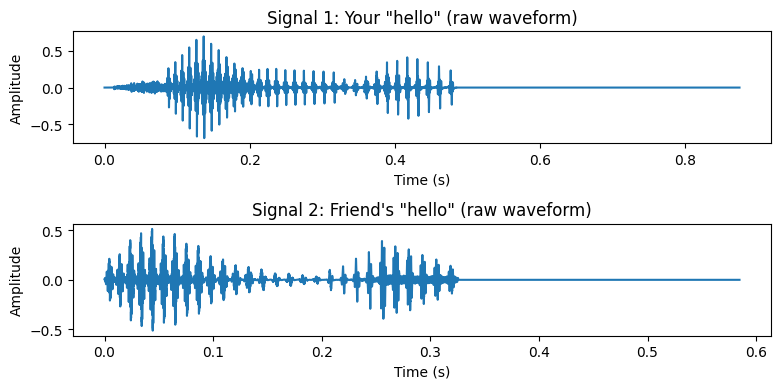

In [ ]:
# Create time axes (in seconds) for both signals
t1 = np.arange(len(signal_1)) / sr_1
t2 = np.arange(len(signal_2)) / sr_2

fig, axes = plt.subplots(2, 1, sharex=False)

# Plot Signal 1
axes[0].plot(t1, signal_1)
axes[0].set_title('Signal 1: Your "hello" (raw waveform)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')

# Plot Signal 2
axes[1].plot(t2, signal_2)
axes[1].set_title('Signal 2: Friend\'s "hello" (raw waveform)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

## 2. Normalize the Signals

To make the signals comparable, we normalize each waveform so that its maximum absolute value is 1.
This removes differences in loudness and focuses DTW on the **shape** of the signals.

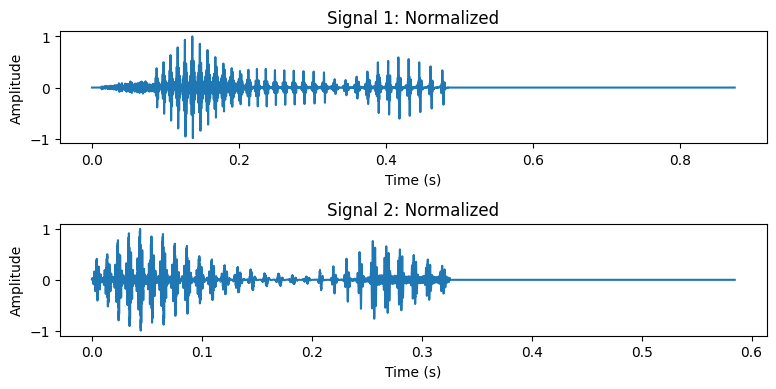

In [ ]:
def normalize_signal(x):
    """Normalize a signal to have maximum absolute value 1.
    If the signal is all zeros, return it unchanged.
    """
    max_val = np.max(np.abs(x))
    if max_val == 0:
        return x
    return x / max_val

signal_1_norm = normalize_signal(signal_1)
signal_2_norm = normalize_signal(signal_2)

# Plot normalized signals
fig, axes = plt.subplots(2, 1, sharex=False)

axes[0].plot(t1, signal_1_norm)
axes[0].set_title('Signal 1: Normalized')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')

axes[1].plot(t2, signal_2_norm)
axes[1].set_title('Signal 2: Normalized')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

#3. Implement the Dynamic Time Warping (DTW) Algorithm

We now implement DTW from scratch for 1D signals. DTW finds the **optimal alignment path** between
two sequences by allowing non-linear stretching and compression along the time axis.

The basic steps:
1. Build a local cost matrix (e.g., absolute difference between samples).
2. Build an accumulated cost matrix using dynamic programming.
3. Backtrack from the bottom-right corner to the top-left to recover the optimal warping path.
4. The final DTW distance is the accumulated cost at the bottom-right corner.

In [ ]:
def dtw_1d(x, y):
    """Compute DTW between two 1D sequences x and y.

    Returns:
        D: accumulated cost matrix
        path: list of index pairs (i, j) representing the optimal warping path
    """
    n = len(x)
    m = len(y)

    # Local cost matrix: absolute difference between every pair of points
    cost = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            cost[i, j] = abs(x[i] - y[j])

    # Accumulated cost matrix, initialized with infinity
    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0

    # Fill the accumulated cost matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Cost of current step
            c = cost[i - 1, j - 1]
            # Minimum of insertion (i-1, j), deletion (i, j-1), match (i-1, j-1)
            D[i, j] = c + min(D[i - 1, j],    # insertion
                              D[i, j - 1],    # deletion
                              D[i - 1, j - 1])  # match

    # Backtracking to find the optimal path
    i, j = n, m
    path = []
    while i > 0 and j > 0:
        path.append((i - 1, j - 1))
        # Move to the neighbor with the smallest accumulated cost
        choices = [D[i - 1, j], D[i, j - 1], D[i - 1, j - 1]]
        arg_min = np.argmin(choices)
        if arg_min == 0:
            i -= 1
        elif arg_min == 1:
            j -= 1
        else:
            i -= 1
            j -= 1

    path.reverse()  # reverse to start from the beginning

    return D[1:, 1:], path

# For speech signals, computing DTW on every sample can be heavy.
# Optionally, you can downsample the signals to speed up DTW.

# Downsample by a factor (for example, keep every 4th sample)
factor = 4
x = signal_1_norm[::factor]
y = signal_2_norm[::factor]

D, path = dtw_1d(x, y)
dtw_distance = D[-1, -1]

print(f"DTW distance between the two normalized signals: {dtw_distance:.4f}")
print(f"Length of warping path: {len(path)}")

DTW distance between the two normalized signals: 134.9312
Length of warping path: 6841


## 4. Visualize the Cost Matrix and Warping Path

The heatmap below shows the accumulated cost matrix `D`. The warping path describes how time
indices in Signal 1 are matched to time indices in Signal 2.

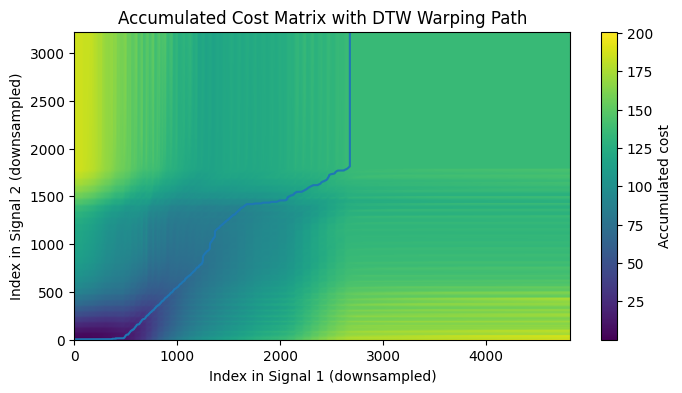

In [ ]:
# Convert path into separate index lists for plotting
path_i = [p[0] for p in path]
path_j = [p[1] for p in path]

plt.figure()
plt.imshow(D.T, origin='lower', aspect='auto')
plt.plot(path_i, path_j)
plt.title('Accumulated Cost Matrix with DTW Warping Path')
plt.xlabel('Index in Signal 1 (downsampled)')
plt.ylabel('Index in Signal 2 (downsampled)')
plt.colorbar(label='Accumulated cost')
plt.show()

## 5. Visualize the Alignment Between the Two Signals

To better understand the warping, we plot the two downsampled signals and draw lines indicating
how DTW aligns each point from Signal 1 to a point in Signal 2.

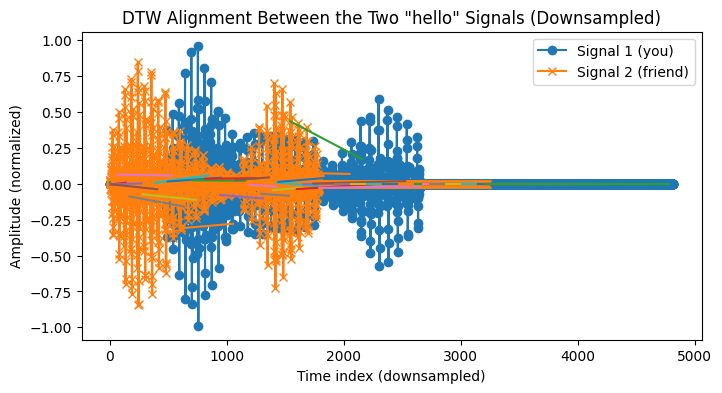

In [ ]:
# Create simple time axes for downsampled signals
tx = np.arange(len(x))
ty = np.arange(len(y))

fig, ax = plt.subplots()
ax.plot(tx, x, label='Signal 1 (you)', marker='o')
ax.plot(ty, y, label="Signal 2 (friend)", marker='x')

# Draw alignment lines for a subset of path points to avoid clutter
step = max(1, len(path) // 50)  # reduce number of lines if path is long
for k in range(0, len(path), step):
    i, j = path[k]
    ax.plot([tx[i], ty[j]], [x[i], y[j]])

ax.set_title('DTW Alignment Between the Two "hello" Signals (Downsampled)')
ax.set_xlabel('Time index (downsampled)')
ax.set_ylabel('Amplitude (normalized)')
ax.legend()
plt.show()

## 6. Interpretation of Results

Now interpret your results based on the plots and DTW distance:

- Look at the **normalized waveforms**: Do they have a similar shape? Are there differences in speed or timing
  (for example, one speaker stretches some part of the word more than the other)?
- Examine the **DTW cost matrix and warping path**:
  - If the path mostly follows the diagonal, the two signals are well aligned in time.
  - If the path moves horizontally or vertically in some regions, DTW is stretching or compressing one signal
    to match the other.
- Consider the **DTW distance value**:
  - A **small DTW distance** indicates that the two signals are quite similar after alignment.
  - A **larger DTW distance** indicates more differences in pronunciation, timing, or background noise.

### Example Discussion (you can adapt this for your report)

- Both speakers say the same word "hello", so the general shape of the waveform is similar
  (a burst at the beginning for /h/, followed by energy for the vowels /e/ and /o/).
- However, one speaker may speak slightly faster or slower, causing the peaks to occur at slightly
  different times.
- DTW allows us to **warp** the time axis and align these peaks, showing that the underlying pattern
  is similar even if the signals do not line up perfectly in time.
- The computed DTW distance quantifies how similar the two utterances are after this time alignment.

You can now write your own inference based on your actual plots and numeric DTW distance.